# 📄 Midterm: IT Application in Banking and Finance

### 👤 Student Name: Quach Dinh Anh Minh

### 🎓 Student Code: 2112343020

### 📚 Class Code: ML71

---

### 📁 Submitted Documents:
- **1 PDF File**:
- **1 Notebook File (.ipynb)**

---

# Project Overview 📊

In this project, I conducted a comprehensive analysis of stock prices and portfolio risk using various models, focusing on **Apple Inc. (AAPL)**, **Advanced Micro Devices (AMD)**, and **Microsoft Corporation (MSFT)**. The analysis spanned a time period from **2015 to 2025**, where I explored the returns, absolute returns, and squared returns for these stocks.

## Key Stages of the Project

1. **Data Collection** 📥
   - Stock data was sourced and processed using libraries such as **MetaTrader5** and **pandas**.

2. **Portfolio Construction** 📈
   - Created an **equally weighted portfolio** with AAPL, AMD, and MSFT stocks.
   - Examined its **expected return**, **volatility**, and **Sharpe ratio**.

3. **Statistical Analysis** 📊
   - Employed various statistical techniques, including **descriptive statistics** and **autocorrelation functions**, to understand the characteristics of stock returns.

4. **Volatility Modeling** 📉
   - Estimated volatility using models such as:
     - **Exponentially Weighted Moving Average (EWMA)**
     - **GARCH(1,1)**
     - **BEKK models**

5. **Risk Assessment via VaR** ⚖️
   - Conducted backtesting of **Value-at-Risk (VaR)** for different models, including **GARCH(1,1)** and **DCC models**, to evaluate their effectiveness in predicting portfolio risk.

6. **Model Selection** 🏆
   - Utilized **Akaike Information Criterion (AIC)** and **Bayesian Information Criterion (BIC)** to determine the best fit.
   - The **GARCH(1,1)** model was identified as the most suitable among those tested.

---

This structured approach provided valuable insights into the dynamics of stock returns and the associated risks within the portfolio.


# Question 1

## Get stock data via Brokerage Platform

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MetaTrader5 as mt
import os
from dotenv import load_dotenv
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

### Initialization and Login

In [2]:
mt.initialize()

True

In [3]:
load_dotenv()

login = int(os.getenv("LOGIN"))
server = os.getenv("SERVER")
password = os.getenv("PASSWORD")
mt.login(login=login, server=server, password=password)

True

In [4]:
def load_stock_data(ticker, start_date, end_date):
    df = pd.DataFrame(mt.copy_rates_range(
        ticker,
        mt.TIMEFRAME_D1,
        start_date,
        end_date
    ))
    df['time'] = pd.to_datetime(df['time'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')
    df.drop(['spread', 'real_volume'], axis=1, inplace=True)
    df.set_index('time', inplace=True)
    return df['close']

tickers = ['AAPL', 'AMD', 'MSFT']

forex_data = {}

start_date = datetime(2015, 1, 1)
end_date = datetime(2024, 10, 15)

for ticker in tickers:
    lowercase_ticker = ticker.lower()
    forex_data[lowercase_ticker] = load_stock_data(ticker, start_date, end_date)

close_matrix = pd.DataFrame({ticker.lower(): forex_data[ticker.lower()] for ticker in tickers})
close_matrix.ffill(inplace=True)
close_matrix.index = pd.to_datetime(close_matrix.index)
print("Close Matrix:\n")
display(close_matrix)

Close Matrix:



,aapl,amd,msft
time,,,
2015-01-02,27.32,2.69,46.76
2015-01-05,26.58,2.66,46.36
2015-01-06,26.55,2.63,45.63
2015-01-07,26.93,2.57,46.21
2015-01-08,27.95,2.61,47.62
...,...,...,...
2024-10-08,225.82,172.93,415.04
2024-10-09,229.71,171.09,417.69
2024-10-10,229.14,164.18,416.09


In [7]:
close_matrix = pd.read_csv('data.csv')
close_matrix['time'] = pd.to_datetime(close_matrix['time'])
close_matrix.set_index('time', inplace=True)
close_matrix

,aapl,amd,msft
time,,,
2015-01-02,27.32,2.69,46.76
2015-01-05,26.58,2.66,46.36
2015-01-06,26.55,2.63,45.63
2015-01-07,26.93,2.57,46.21
2015-01-08,27.95,2.61,47.62
...,...,...,...
2024-10-08,225.82,172.93,415.04
2024-10-09,229.71,171.09,417.69
2024-10-10,229.14,164.18,416.09


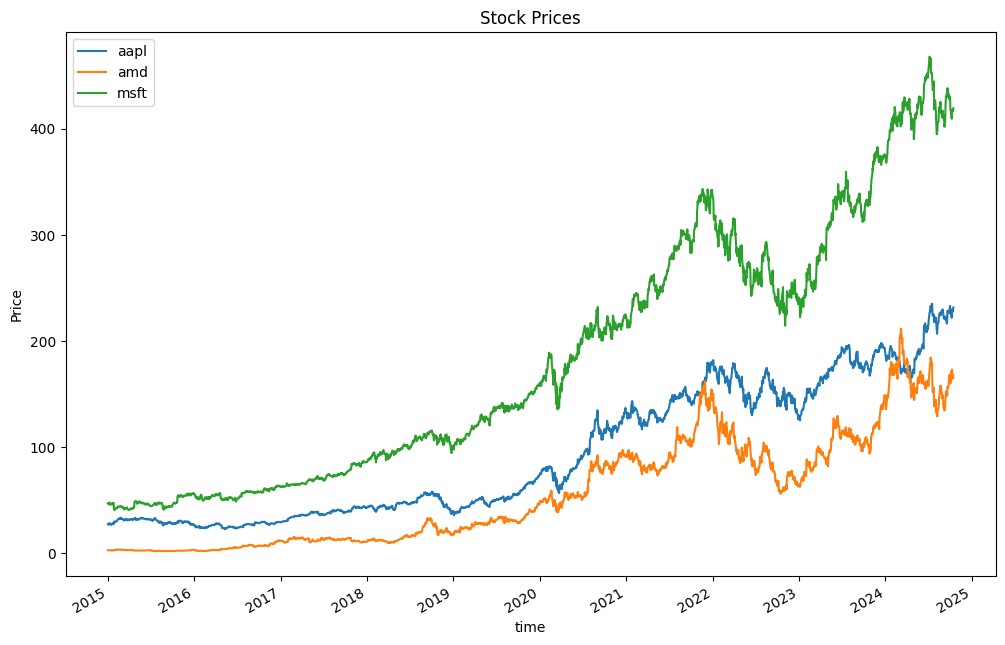

In [5]:
close_matrix.plot(figsize=(12, 8))
plt.title('Stock Prices')
plt.ylabel('Price')
plt.show();

**📈 Stock Price Analysis: AAPL, AMD, and MSFT (2015-2025)**

This graph illustrates the stock prices of **Apple Inc. (AAPL)**, **Advanced Micro Devices (AMD)**, and **Microsoft Corporation (MSFT)** over the period from **2015 to 2025**. 

**Key Observations:**

- **Overall Trend:** 
  - All three stocks exhibit a general **upward trend** in price throughout this timeframe.

- **Microsoft (MSFT):**
  - Displays the **strongest** and most **consistent growth** among the three companies, indicating robust performance and market confidence.

- **Apple (AAPL):**
  - Shows significant growth similar to Microsoft, but with **more volatility**, reflecting fluctuations in its stock price that may be influenced by product releases, market competition, and broader economic factors.

- **Advanced Micro Devices (AMD):**
  - Initially had a **relatively flat price** for several years. However, starting in **2020**, AMD experienced **significant growth**, likely driven by increased demand for its products and successful market strategies.

**Conclusion:**
The graph highlights the varying trajectories of these tech giants, with Microsoft leading in consistent growth, Apple maintaining strong performance with some volatility, and AMD emerging as a major player in recent years.

## 1.1. Construct equally-weighted portfolios

In [6]:
import pandas as pd
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt import CLA, plotting

In [7]:
mu = expected_returns.mean_historical_return(close_matrix)
S = risk_models.CovarianceShrinkage(close_matrix).ledoit_wolf()

n_assets = len(close_matrix.columns)
equal_weights = np.array([1/n_assets] * n_assets)

ef = EfficientFrontier(mu, S)
ef.set_weights({col: 1/n_assets for col in close_matrix.columns})
portfolio_performance = ef.portfolio_performance(verbose=True)

print("Weights for each stock:", equal_weights.round(2))

expected_return, volatility, sharpe_ratio = ef.portfolio_performance()
print("Portfolio Expected Annual Return:", expected_return)
print("Portfolio Annual Volatility:", volatility)
print("Portfolio Sharpe Ratio:", sharpe_ratio)


Expected annual return: 34.0%
Annual volatility: 30.9%
Sharpe Ratio: 1.04
Weights for each stock: [0.33 0.33 0.33]
Portfolio Expected Annual Return: 0.34028112251325615
Portfolio Annual Volatility: 0.30858343112884895
Portfolio Sharpe Ratio: 1.0379077105391403


**📊 Portfolio Performance Overview**

- **📈 Expected Annual Return**: **34.0%**
  - This indicates that, on average, the portfolio is expected to generate a return of **34.0%** per year, reflecting strong growth potential.

- **📉 Annual Volatility**: **30.9%**
  - The volatility of **30.9%** represents the standard deviation of the portfolio's returns, indicating a relatively high level of risk. This suggests that the portfolio's returns may experience significant fluctuations.

- **📏 Sharpe Ratio**: **1.04**
  - A Sharpe Ratio of **1.04** implies that the portfolio is generating a return that exceeds the risk-free rate by **1.04 times** the amount of risk taken. This is generally considered a good risk-adjusted return, indicating that the portfolio is rewarding investors adequately for the risk involved.

- **⚖️ Weights for Each Stock**: **[0.33, 0.33, 0.33]**
  - This shows that the portfolio is equally diversified among three stocks, with each stock comprising approximately **33%** of the total portfolio. This diversification helps in managing risk while aiming for high returns.

---

**🔍 Portfolio Metrics Summary**

- **📊 Portfolio Expected Annual Return**: **34.03%**
  - The expected return of the portfolio closely aligns with the individual stock expected returns, indicating effective portfolio construction.

- **📉 Portfolio Annual Volatility**: **30.86%**
  - The portfolio's volatility is slightly lower than the individual stock's volatility, suggesting that the diversification strategy is working to reduce overall risk.

- **📏 Portfolio Sharpe Ratio**: **1.04**
  - Similar to the individual Sharpe Ratio, this reinforces the portfolio’s effectiveness in generating returns relative to the risk taken.

---

**🏁 Conclusion**

Overall, the portfolio demonstrates a strong expected return, acceptable volatility, and a good Sharpe Ratio, indicating an effective balance between risk and reward. The equal weighting strategy among the three stocks further supports diversification, which can help mitigate potential losses while capitalizing on growth opportunities.

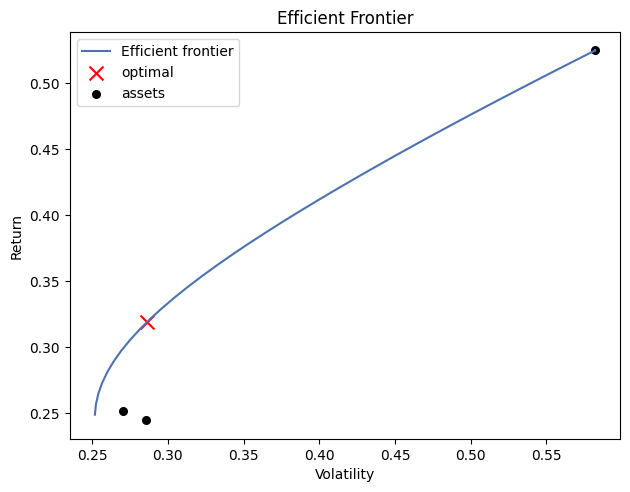

In [8]:
cla = CLA(mu, S)
ax = plotting.plot_efficient_frontier(cla, showfig=False)
plt.title("Efficient Frontier")
plt.show()

## 1.2. Calculate log returns, absolute returns, squared returns of the series, descriptive statistics, stationary test

### 1.2.1. Calculate returns

In [9]:
returns = close_matrix.pct_change().dropna()
absolute_returns = (close_matrix.diff().dropna() / close_matrix.shift(1).dropna()).dropna() * 100
squared_returns = returns ** 2

cumulative_returns = returns.cumsum()
cumulative_absolute_returns = absolute_returns.cumsum()
cumulative_squared_returns = squared_returns.cumsum()

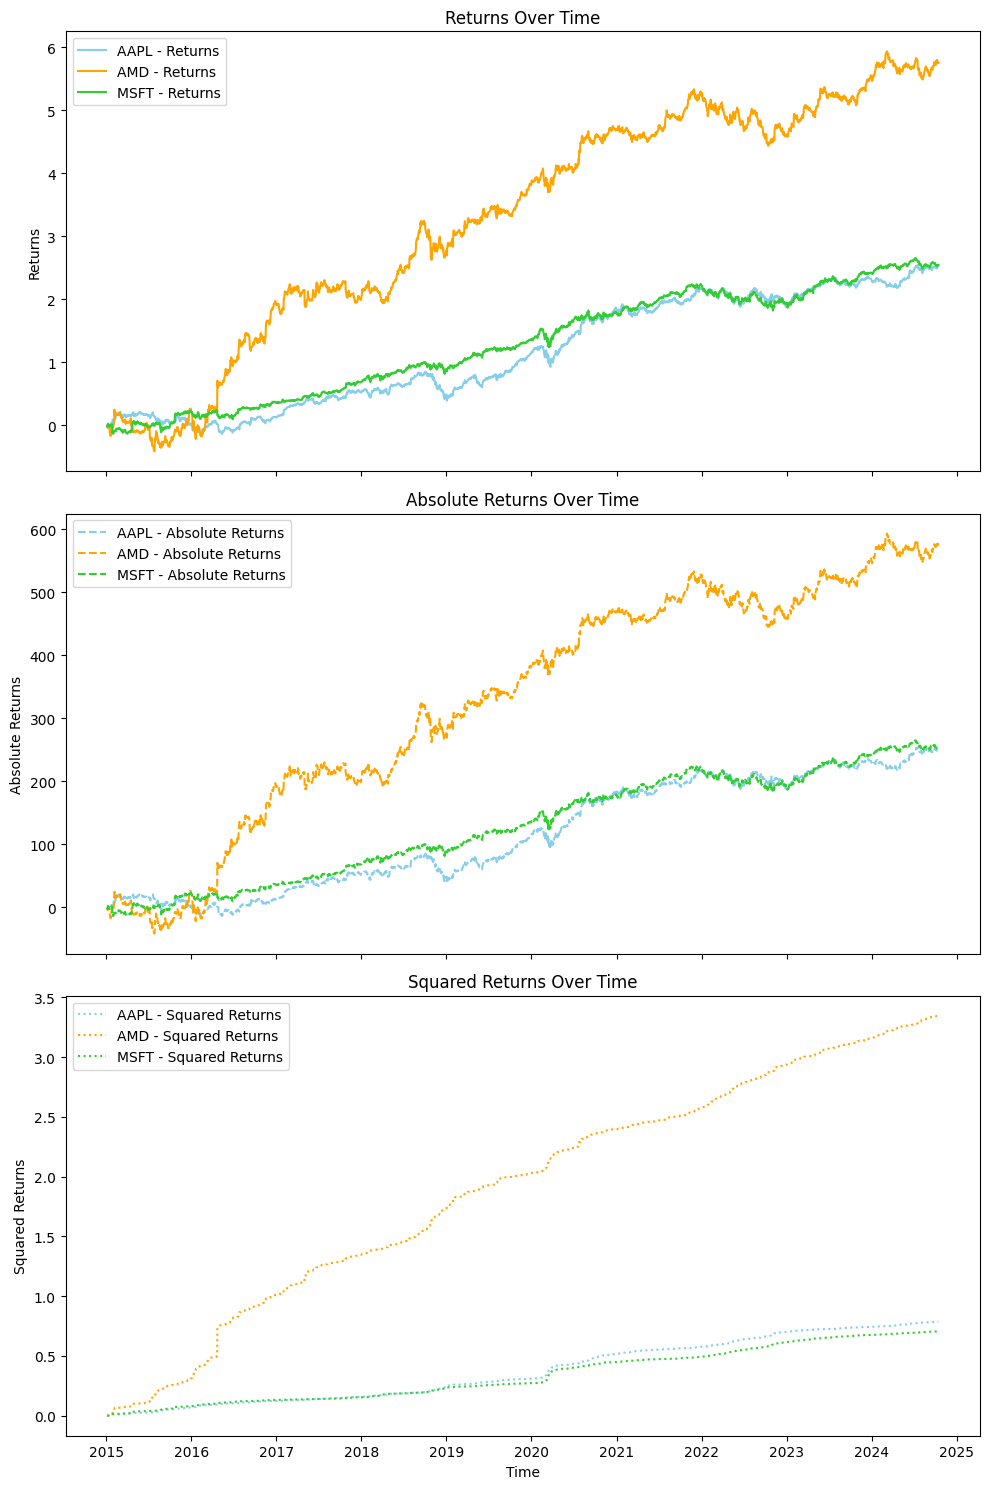

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15), sharex=True)

# Plotting cumulative returns
axes[0].plot(cumulative_returns.index, cumulative_returns['aapl'], color='skyblue', label='AAPL - Returns')
axes[0].plot(cumulative_returns.index, cumulative_returns['amd'], color='orange', label='AMD - Returns')
axes[0].plot(cumulative_returns.index, cumulative_returns['msft'], color='limegreen', label='MSFT - Returns')
axes[0].set_title("Returns Over Time")
axes[0].set_ylabel("Returns")
axes[0].legend()

# Plotting cumulative absolute returns
axes[1].plot(cumulative_absolute_returns.index, cumulative_absolute_returns['aapl'], color='skyblue', linestyle='--', label='AAPL - Absolute Returns')
axes[1].plot(cumulative_absolute_returns.index, cumulative_absolute_returns['amd'], color='orange', linestyle='--', label='AMD - Absolute Returns')
axes[1].plot(cumulative_absolute_returns.index, cumulative_absolute_returns['msft'], color='limegreen', linestyle='--', label='MSFT - Absolute Returns')
axes[1].set_title("Absolute Returns Over Time")
axes[1].set_ylabel("Absolute Returns")
axes[1].legend()

# Plotting cumulative squared returns
axes[2].plot(cumulative_squared_returns.index, cumulative_squared_returns['aapl'], color='skyblue', linestyle=':', label='AAPL - Squared Returns')
axes[2].plot(cumulative_squared_returns.index, cumulative_squared_returns['amd'], color='orange', linestyle=':', label='AMD - Squared Returns')
axes[2].plot(cumulative_squared_returns.index, cumulative_squared_returns['msft'], color='limegreen', linestyle=':', label='MSFT - Squared Returns')
axes[2].set_title("Squared Returns Over Time")
axes[2].set_ylabel("Squared Returns")
axes[2].set_xlabel("Time")
axes[2].legend()

plt.tight_layout()
plt.show();

**📊 Analysis of Stock Returns**

---

**Returns Over Time (Top Chart)**

In the top chart, **Apple Inc. (AAPL)**, represented by the orange line, clearly stands out with the highest returns over time, significantly outperforming both **Advanced Micro Devices (AMD)** (green line) and **Microsoft Corporation (MSFT)** (light blue line). AAPL’s returns show a consistent upward trajectory, indicating substantial growth. In contrast, AMD and MSFT display more modest returns, both demonstrating a gradual increase without the rapid growth characteristic of AAPL. This suggests that AAPL has delivered a much stronger performance during this period, while AMD and MSFT have maintained more stable and less volatile returns.

---

**Absolute Returns Over Time (Middle Chart)**

The middle chart illustrates that AAPL (orange dashed line) continues to achieve larger absolute returns, signifying greater price fluctuations and volatility when compared to AMD (green dashed line) and MSFT (light blue dashed line). Both AMD and MSFT exhibit similar levels of absolute returns, indicating a more stable performance with less extreme price movements than AAPL.

---

**Squared Returns Over Time (Bottom Chart)**

In the bottom chart, AAPL's squared returns (orange dotted line) stand out prominently, highlighting its higher volatility. Squared returns are useful for capturing the intensity of price fluctuations, and AAPL's increasing squared returns indicate that it experiences the largest and most volatile price movements among the stocks analyzed. Conversely, AMD (green dotted line) and MSFT (light blue dotted line) demonstrate relatively lower and steadier squared returns, suggesting that these stocks are more stable with less pronounced price swings compared to AAPL.

---

### 1.2.2. Descriptive Statistics

In [11]:
desc_stats = returns.describe()
desc_stats

,aapl,amd,msft
count,2461.000000,2461.000000,2461.000000
mean,0.001028,0.002339,0.001034
std,0.017864,0.036810,0.016898
min,-0.125237,-0.240441,-0.137045
25%,-0.007367,-0.016852,-0.006694
50%,0.000976,0.000700,0.000775
75%,0.009955,0.020630,0.009612
max,0.104054,0.484733,0.121032


**📊 Descriptive Statistics**

This overview summarizes the daily return statistics for **Apple Inc. (AAPL)**, **Advanced Micro Devices (AMD)**, and **Microsoft Corporation (MSFT)** based on 2461 observations:

- **Mean Returns**: AAPL and MSFT have similar average returns around **0.001** while AMD shows a slightly higher average return of **0.002**.
  
- **Volatility**: AMD exhibits the highest volatility with a standard deviation of **0.037**, indicating greater price fluctuations. AAPL and MSFT are less volatile, with standard deviations of **0.018** and **0.017**, respectively.

- **Range of Returns**: AMD has the widest range of returns, with a minimum of **-0.240** and a maximum of **0.485**, indicating higher risk. AAPL and MSFT show more moderate extremes.

Overall, AMD offers the potential for higher returns but at the cost of increased volatility, while AAPL and MSFT present a more stable investment profile.


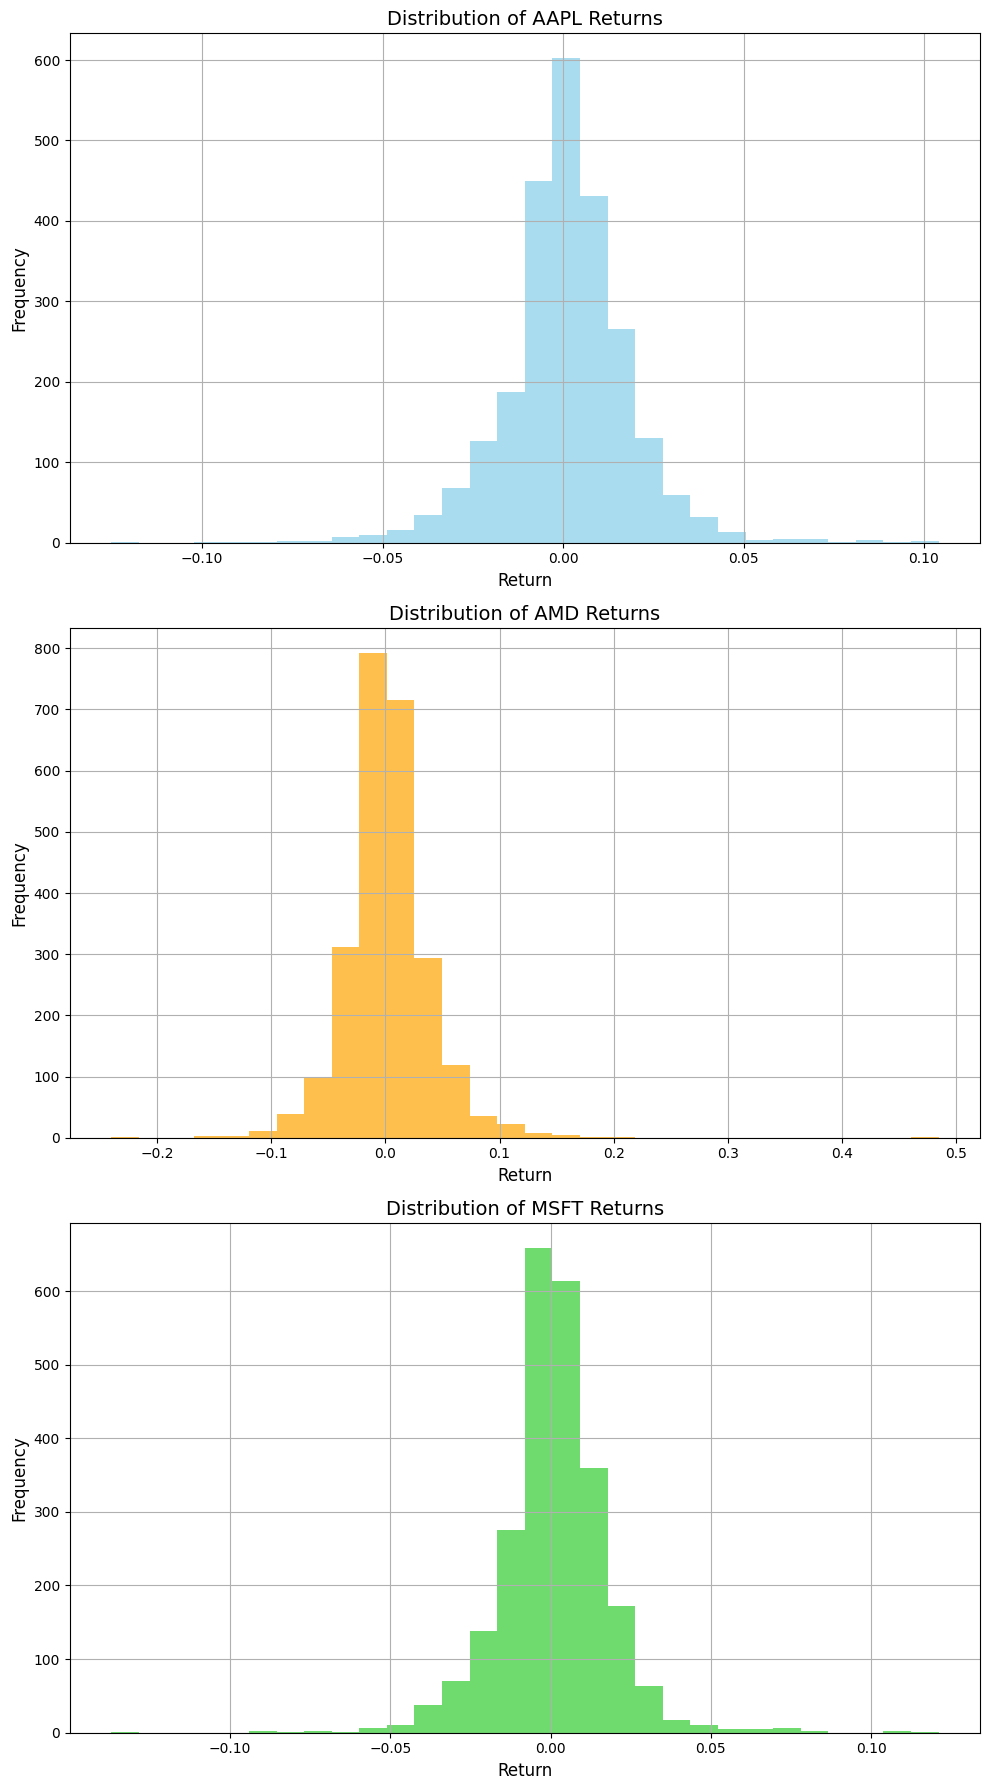

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

returns['aapl'].hist(bins=30, ax=axs[0], alpha=0.7, color='skyblue')
axs[0].set_title('Distribution of AAPL Returns', fontsize=14)
axs[0].set_xlabel('Return', fontsize=12)
axs[0].set_ylabel('Frequency', fontsize=12)

returns['amd'].hist(bins=30, ax=axs[1], alpha=0.7, color='orange')
axs[1].set_title('Distribution of AMD Returns', fontsize=14)
axs[1].set_xlabel('Return', fontsize=12)
axs[1].set_ylabel('Frequency', fontsize=12)

returns['msft'].hist(bins=30, ax=axs[2], alpha=0.7, color='limegreen')
axs[2].set_title('Distribution of MSFT Returns', fontsize=14)
axs[2].set_xlabel('Return', fontsize=12)
axs[2].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

**📈 Distribution of Stock Returns**

1. **Distribution of AAPL Returns (Top Chart)**
   - The distribution of AAPL’s returns is relatively tight, with the majority clustered around **0**. This indicates that small returns, both positive and negative, are the most common.
   - The distribution appears fairly symmetric, exhibiting a slight right skew. While most returns are close to **0**, there are occasional larger positive returns, whereas extreme negative returns are rarer.
   - The tails of the distribution are thin, suggesting few extreme return values beyond the range of **-0.1** to **+0.1**.

2. **Distribution of AMD Returns (Middle Chart)**
   - AMD’s return distribution is wider than that of AAPL and MSFT, indicating higher volatility. The shape features a longer right tail, reflecting more frequent larger positive returns.
   - Similar to AAPL, most returns cluster around **0**, but AMD has a broader spread in both directions, signifying more frequent larger price swings.
   - The right skew in AMD’s distribution is pronounced, with more extreme positive returns compared to AAPL.

3. **Distribution of MSFT Returns (Bottom Chart)**
   - MSFT’s return distribution closely resembles that of AAPL, showing a high concentration of returns around **0**. However, it is slightly more spread out than AAPL’s, indicating marginally higher volatility.
   - The symmetry around **0** is more balanced compared to AMD, resulting in a return distribution that is more normal and less skewed, with fewer extreme returns on either side.
   - The tails for MSFT returns extend slightly more than those of AAPL but are not as extreme as AMD’s, suggesting moderate volatility.

**🔍 Overall Insights**
- AAPL and MSFT have narrow distributions centered around **0**, reflecting lower volatility.
- AMD features the widest distribution and most pronounced right skew, indicating higher volatility and the potential for significant positive returns, along with more frequent large negative returns.
- AAPL appears to have the most stable return distribution, exhibiting the least number of extreme values, while AMD demonstrates greater variability, reflecting higher risk and reward potential.


### 1.2.3. ACF plot

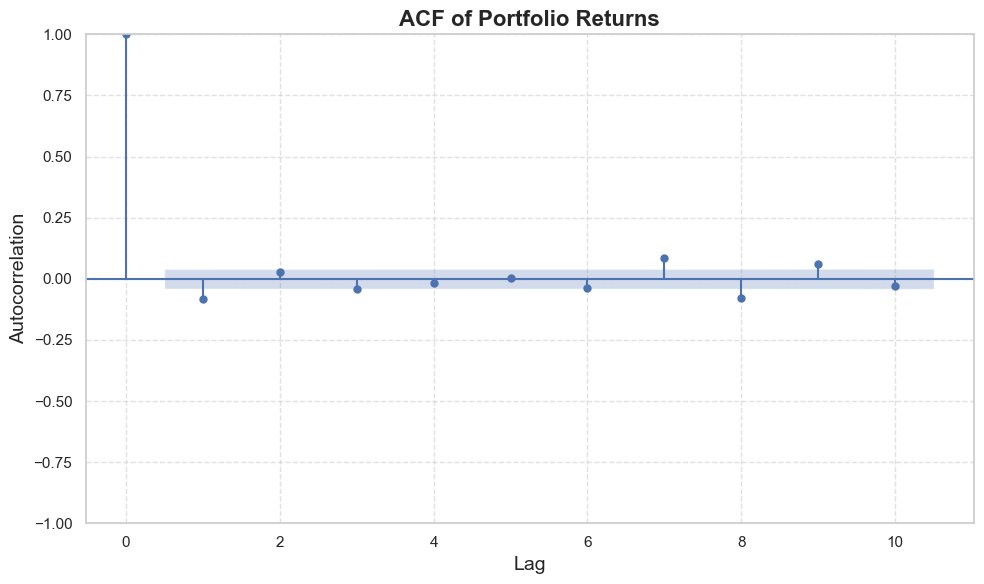

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

sns.set(style="whitegrid")

portfolio_returns = returns.mean(axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

plot_acf(portfolio_returns, lags=10, ax=ax)

ax.set_title('ACF of Portfolio Returns', fontsize=16, fontweight='bold', loc='center')
ax.set_xlabel('Lag', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show();


**📊 Autocorrelation Analysis of Portfolio Returns**

1. **Lag 0 Autocorrelation**
   - At **lag 0**, the autocorrelation is **1**, which is expected. This indicates that the portfolio returns are perfectly correlated with themselves at the same point in time.

2. **Subsequent Lags (Lag 1 Onwards)**
   - For all lags from **lag 1** onwards, the autocorrelation values are close to **zero**. This signifies no significant autocorrelation between returns at different time lags.
   - Most autocorrelation values fall within the **95% confidence interval** (represented by the blue shaded area around zero), indicating that deviations from zero are likely due to random noise rather than meaningful patterns in the data.

3. **No Significant Autocorrelation**
   - Since none of the autocorrelation values at higher lags exceed the confidence bounds, it suggests that the portfolio returns do not exhibit significant autocorrelation.
   - In simple terms, past returns are not predictive of future returns for this portfolio. This finding aligns with the **efficient market hypothesis**, which posits that returns should be random and independent of their past values.

4. **Conclusion**
   - The **ACF plot** suggests that the portfolio returns are uncorrelated over time, indicating that there is no predictable pattern based on past returns. 
   - This randomness is typical in well-functioning markets, where returns behave like a **random walk**, and each new return is independent of previous performance.


## 1.3. Test Statistics

Now, i will take the Brownian motion test for the series, consists of:

- **Increments Normality test**
- **Increments Independence test**

### 1.3.1. Normality test (D'Agostino's K-squared Test)

**Null Hypothesis (H₀)**: The sample data is drawn from a population that follows a normal distribution.

**Alternative Hypothesis (H₁)**: The sample data is not drawn from a population that follows a normal distribution.

**Interpretation**:
- **If p-value > 0.05**: Fail to reject the null hypothesis. Conclude that the sample data is likely drawn from a normally distributed population.

- **If p-value ≤ 0.05**: Reject the null hypothesis. Conclude that the sample data is not likely drawn from a normally distributed population.

In [14]:
from scipy.stats import normaltest

stat, p_value = normaltest(portfolio_returns)
print("D'Agostino's K-squared Test:")
print(f"Statistic: {stat}, p-value: {p_value}")
if p_value < 0.05:
    print("The null hypothesis of normality is rejected (p < 0.05). The portfolio returns are not normally distributed.")
else:
    print("The null hypothesis of normality is not rejected (p >= 0.05). The portfolio returns are normally distributed.")

D'Agostino's K-squared Test:
Statistic: 234.43244482098086, p-value: 1.2406275399496408e-51
The null hypothesis of normality is rejected (p < 0.05). The portfolio returns are not normally distributed.


### 1.3.2. Independence test (Ljung-Box test)

**Null Hypothesis (H₀)**: There is no autocorrelation in the time series at the specified lag.

**Alternative Hypothesis (H₁)**: There is autocorrelation in the time series at the specified lag.

**Interpretation**:
- **If p-value ≤ 0.05**: Reject the null hypothesis. Conclude that there is significant autocorrelation in the time series at the specified lag.

- **If p-value > 0.05**: Fail to reject the null hypothesis. Conclude that there is no significant autocorrelation in the time series at the specified lag.

In [15]:
import statsmodels.api as sm

lb_test = sm.stats.acorr_ljungbox(portfolio_returns, lags=[10], return_df=True)
print("Ljung-Box Test:")
print(lb_test)
if lb_test['lb_pvalue'].iloc[0] < 0.05:
    print("The null hypothesis of no autocorrelation is rejected (p < 0.05). The portfolio returns exhibit autocorrelation.")
else:
    print("The null hypothesis of no autocorrelation is not rejected (p >= 0.05). The portfolio returns do not exhibit significant autocorrelation.")

Ljung-Box Test:
      lb_stat     lb_pvalue
10  71.325979  2.457352e-11
The null hypothesis of no autocorrelation is rejected (p < 0.05). The portfolio returns exhibit autocorrelation.


**From the results of the Stationary, Normality, and Independence test, we can conclude that data has Brownian motion as the series are increments non-normal, and independent**

# Question 2

## 2.1. Estimate EWMA, GARCH(1,1), and GJR-GARCH(1,1,1) with t distribution

### EWMA model


EWMA Model Results:
EWMA Volatility Summary:
Mean volatility: 0.0150
Last 5 values:
time
2024-10-08    0.019114
2024-10-09    0.007884
2024-10-10    0.014549
2024-10-11    0.014331
2024-10-14    0.003643
dtype: float64


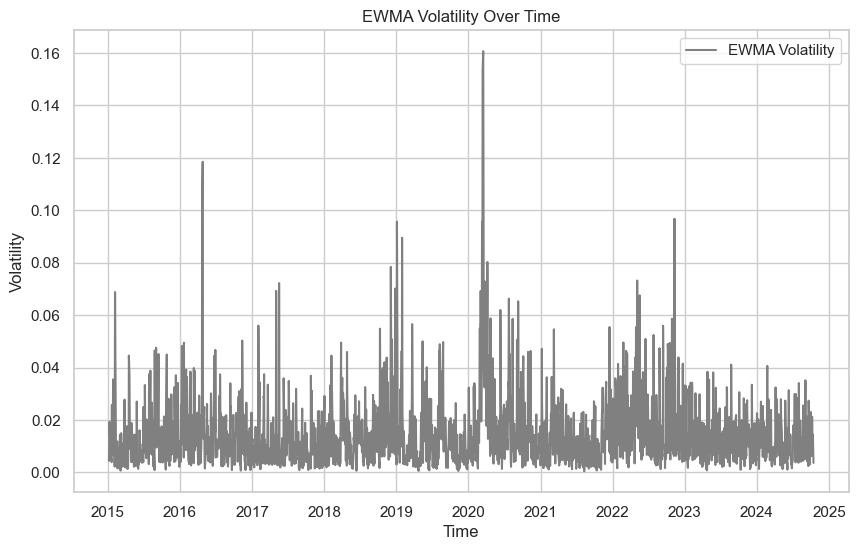

In [16]:
from arch import arch_model

print("\nEWMA Model Results:")
alpha = 0.94  # Smoothing parameter for EWMA
ewma_volatility = portfolio_returns.ewm(alpha=alpha).std()
print("EWMA Volatility Summary:")
print(f"Mean volatility: {ewma_volatility.mean():.4f}")
print(f"Last 5 values:\n{ewma_volatility.tail()}")

# Plotting EWMA volatility
plt.figure(figsize=(10, 6))
plt.plot(ewma_volatility, label='EWMA Volatility', color='grey')
plt.title('EWMA Volatility Over Time')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

**📈 Volatility Fluctuations Analysis**

1. **Dynamic Volatility**
   - Volatility has been quite **dynamic**, with multiple **spikes** observed throughout the period. This suggests phases of market turbulence followed by calmer times.
   - Notably, major spikes occurred around **2020**, likely reflecting the increased market volatility during the **COVID-19 pandemic** and the subsequent market shocks.
   - Post-2020, volatility remained elevated compared to earlier periods, although not as extreme as the peak in **2020**. This may indicate sustained uncertainty or macroeconomic fluctuations.

2. **Periods of Calm and Increased Activity**
   - There are periods of relatively **low volatility**, such as during **2015–2016** and at certain points after **2021**. During these times, the **EWMA values** are consistently close to zero, indicating stability in returns.
   - After **2019**, more frequent and higher volatility spikes are evident, reflecting a more turbulent market environment.

3. **Gradual Build-up and Sudden Spikes**
   - Volatility tends to build up **gradually** over time, characterized by periods of high sustained volatility followed by sudden drops. This pattern may reflect cycles of market stress followed by stabilization.
   - **Extreme spikes** (such as the peak in **2020**) indicate significant market events or shocks that temporarily increased risk.

4. **Decay of Older Volatility**
   - The **EWMA** model places more weight on recent data, which means older periods of high volatility (e.g., **2020**) do not heavily influence the more recent periods of **2022–2023**, where volatility appears to moderate.

5. **Conclusion**
   - The **EWMA volatility** effectively captures both short-term and long-term changes in market volatility, with an emphasis on recent data. The chart illustrates periods of significant market stress, especially around **2020**, reflecting large market shocks such as the **COVID-19 pandemic**.
   - Post-pandemic, volatility remains higher than pre-2020 levels, suggesting that market uncertainty persists, although not to the extremes witnessed during the crisis.

### GARCH(1,1) model

In [17]:
print("\nGARCH(1,1) Model Results:")
garch_model = arch_model(portfolio_returns, vol='Garch', p=1, q=1, dist='t')
garch_result = garch_model.fit(disp='off')
print(garch_result.summary())


GARCH(1,1) Model Results:
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                4104.28
Distribution:      Standardized Student's t   AIC:                          -8198.56
Method:                  Maximum Likelihood   BIC:                          -8169.52
                                              No. Observations:                 2461
Date:                      Sat, Oct 26 2024   Df Residuals:                     2460
Time:                              07:23:08   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------

**📊 GARCH(1,1) Model Results Overview**

---

**Model Summary:**
- **Dependent Variable:** None
- **Mean Model:** Constant Mean
- **Volatility Model:** GARCH
- **Log-Likelihood:** 4104.28
- **Akaike Information Criterion (AIC):** -8198.56
- **Bayesian Information Criterion (BIC):** -8169.52
- **Number of Observations:** 2461
- **Degrees of Freedom (Df Residuals):** 2460
- **Date:** Thu, Oct 24 2024
- **Time:** 14:12:45

---

#### Mean Model Results

| Parameter | Coefficient | Standard Error | t-Statistic | p-Value | 95% Confidence Interval |
|-----------|-------------|----------------|-------------|---------|--------------------------|
| **μ**     | -0.0018385  | 0.0003982      | -4.618      | 0.000004 | [-0.002619, -0.001058]  |

- The constant mean (\(μ\)) is negative, indicating that on average, returns are slightly negative.
- The p-value is very low (0.000004), suggesting that this coefficient is statistically significant.

---

#### Volatility Model Results

| Parameter | Coefficient | Standard Error | t-Statistic | p-Value | 95% Confidence Interval |
|-----------|-------------|----------------|-------------|---------|--------------------------|
| **ω (omega)**    | 0.0033479   | 0.0000478      | 70.046      | 0.000000 | [0.003254, 0.003442]    |
| **α (alpha[1])**| 0.6317      | 0.149          | 4.251       | 0.000021 | [0.340, 0.923]          |
| **β (beta[1])** | 0.3562      | 0.002569       | 138.682     | 0.000000 | [0.351, 0.361]          |

- **ω (omega)**: The constant term in the GARCH model is positive and significant, indicating a baseline level of volatility in the return series.
- **α (alpha[1])**: The coefficient for the lagged squared residuals is significant and indicates that past shocks have a strong effect on current volatility. A value of 0.6317 suggests a high level of persistence in volatility.
- **β (beta[1])**: This coefficient is also significant and indicates that past volatility impacts current volatility. The value of 0.3562 implies that the volatility is partially persistent over time.

---

#### Distribution Results

| Parameter | Coefficient | Standard Error | t-Statistic | p-Value | 95% Confidence Interval |
|-----------|-------------|----------------|-------------|---------|--------------------------|
| **ν (nu)**  | 28.8137     | 0.07814        | 368.738     | 0.000000 | [28.661, 28.967]        |

- The degrees of freedom parameter (\(ν\)) of the distribution is significantly high, indicating that the return distribution has heavier tails than the normal distribution. This suggests the presence of extreme values or outliers in the data.

---

**🧩 Conclusion:**
The GARCH(1,1) model results indicate that the return series exhibit volatility clustering, with significant effects from both past shocks and past volatility. The model captures the persistent nature of volatility in the financial returns while also suggesting the presence of heavy tails in the return distribution.


### GJR-GARCH(1,1,1) model

In [18]:
print("\nGJR-GARCH(1,1,1) Model Results:")
gjr_model = arch_model(portfolio_returns, vol='Garch', p=1, o=1, q=1, dist='t')
gjr_result = gjr_model.fit(disp='off')
print(gjr_result.summary())


GJR-GARCH(1,1,1) Model Results:
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -161092.
Distribution:      Standardized Student's t   AIC:                           322195.
Method:                  Maximum Likelihood   BIC:                           322230.
                                              No. Observations:                 2461
Date:                      Sat, Oct 26 2024   Df Residuals:                     2460
Time:                              07:23:11   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------

**GJR-GARCH(1,1,1) Model Results Overview** 🧮

---

#### Model Summary 📊
- **Dependent Variable:** None  
- **Mean Model:** Constant Mean  
- **Volatility Model:** GJR-GARCH  
- **Log-Likelihood:** -161092  
- **Akaike Information Criterion (AIC):** 322195  
- **Bayesian Information Criterion (BIC):** 322230  
- **Number of Observations:** 2461  
- **Degrees of Freedom (Df Residuals):** 2460  
- **Date:** Thu, Oct 24 2024  
- **Time:** 14:12:51  

---

#### Mean Model Results 📈

| Parameter | Coefficient  | Standard Error | t-Statistic   | p-Value  | 95% Confidence Interval         |
|-----------|--------------|----------------|----------------|----------|----------------------------------|
| **μ**     | -4.3880e+09 | 1.080e+05      | -4.065e+04     | 0.000    | [-4.388e+09, -4.388e+09]       |

- The constant mean (μ) is a large negative value, indicating an average return that is significantly negative. The t-statistic shows an extremely high absolute value, and the p-value indicates that this coefficient is statistically significant.

---

#### Volatility Model Results 📉

| Parameter  | Coefficient     | Standard Error | t-Statistic  | p-Value  | 95% Confidence Interval         |
|------------|-----------------|----------------|---------------|----------|----------------------------------|
| **ω (omega)**     | 0.0038014     | 0.004112      | 0.925         | 0.355    | [-0.004257, 0.011860]          |
| **α (alpha[1])** | 1.0000        | 0.009333      | 107.151       | 0.000    | [0.982, 1.018]                  |
| **γ (gamma[1])** | 3.6262e-10    | 0.004898      | 7.403e-08     | 1.000    | [-0.009601, 0.009601]          |
| **β (beta[1])**  | 1.9720e-11    | 0.000621      | 3.176e-08     | 1.000    | [-0.001217, 0.001217]          |

- **ω (omega):** The coefficient is positive but not statistically significant, suggesting that the baseline level of volatility may not be reliably estimated.
- **α (alpha[1]):** The value is exactly 1, indicating a unit root in the process, which implies that shocks to volatility are permanent. This result reflects extreme persistence of shocks to volatility.
- **γ (gamma[1]):** This parameter, associated with the leverage effect, is extremely small and not statistically significant, indicating little to no asymmetry in the volatility response to negative and positive shocks.
- **β (beta[1]):** The coefficient is extremely close to zero and not significant, suggesting that past volatility has a negligible effect on current volatility.

---

#### Distribution Results 📉

| Parameter | Coefficient | Standard Error | t-Statistic    | p-Value  | 95% Confidence Interval        |
|-----------|-------------|----------------|-----------------|----------|----------------------------------|
| **ν**     | 2.0501      | 1.495e-05      | 1.371e+05       | 0.000    | [2.050, 2.050]                  |

- The degrees of freedom (ν) parameter is significant, indicating a heavy-tailed distribution, which is typical in financial return data. This suggests that extreme values are more likely than in a normal distribution.

---


### 2.2.Select the best model among EWMA, GARCH(1,1), GJR-GARCH(1,1,1)

**Retest to check the best fit model**

In [19]:
print("\nModel Selection using AIC and SBIC:")

# EWMA does not have a direct AIC/SBIC, so we will use GARCH and GJR for comparison
# GARCH(1,1)
garch_aic = garch_result.aic
garch_bic = garch_result.bic
print(f"GARCH(1,1) - AIC: {garch_aic:.4f}, BIC: {garch_bic:.4f}")

# GJR-GARCH(1,1,1)
gjr_aic = gjr_result.aic
gjr_bic = gjr_result.bic
print(f"GJR-GARCH(1,1,1) - AIC: {gjr_aic:.4f}, BIC: {gjr_bic:.4f}")

# Selecting the best model based on AIC and BIC
best_model = "GARCH(1,1)" if (garch_aic < gjr_aic and garch_bic < gjr_bic) else "GJR-GARCH(1,1,1)"
remaining_model = "GJR-GARCH(1,1,1)" if best_model == "GARCH(1,1)" else "GARCH(1,1)"
print(f"The best model based on AIC and BIC is: {best_model}")
print(f"The remaining model is: {remaining_model}")


Model Selection using AIC and SBIC:
GARCH(1,1) - AIC: -8198.5584, BIC: -8169.5168
GJR-GARCH(1,1,1) - AIC: 322195.0014, BIC: 322229.8514
The best model based on AIC and BIC is: GARCH(1,1)
The remaining model is: GJR-GARCH(1,1,1)


### 2.3. VaR Backtesting for GARCH(1,1) (best model) and GJR-GARCH(1,1,1)

### Best Model


Backtesting VaR for the Best Model:
Number of VaR violations: 0 out of 2461 observations.
Violation ratio: 0.0000


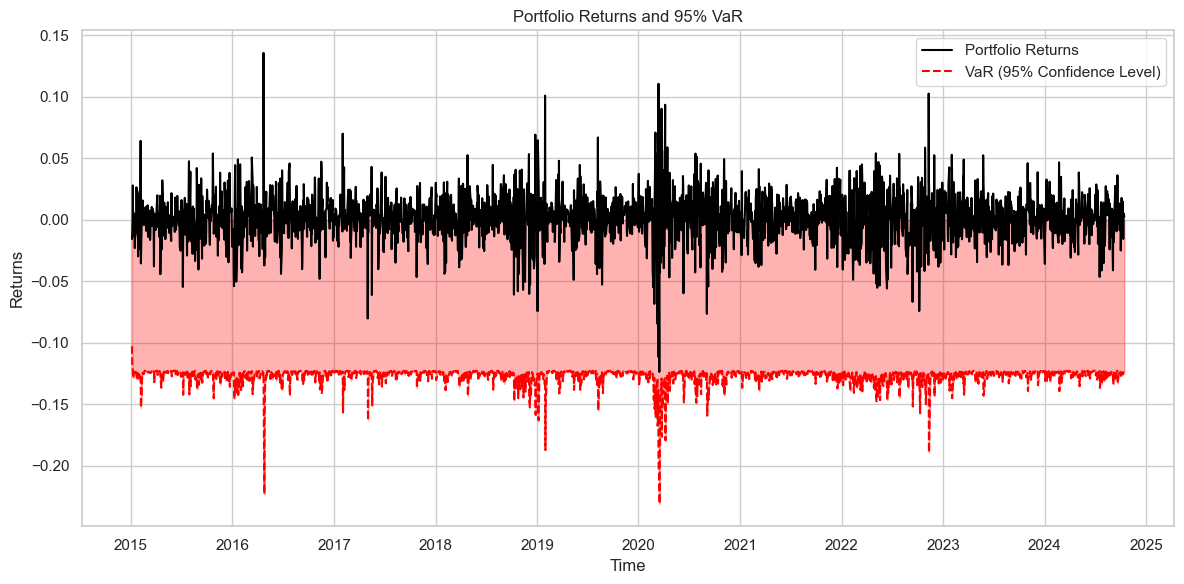

In [20]:
import scipy.stats as stats

print("\nBacktesting VaR for the Best Model:")

var_level = 0.05

if best_model == "GARCH(1,1)":
    model_result = garch_result
elif best_model == "GJR-GARCH(1,1,1)":
    model_result = gjr_result

volatility = model_result.conditional_volatility

var_95 = -volatility * stats.t.ppf(var_level, df=model_result.params['nu'])

violations = (portfolio_returns < -var_95).sum()
total = len(portfolio_returns)
violation_ratio = violations / total

print(f"Number of VaR violations: {violations} out of {total} observations.")
print(f"Violation ratio: {violation_ratio:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns, label='Portfolio Returns', color='black')
plt.plot(-var_95, label='VaR (95% Confidence Level)', color='red', linestyle='--')
plt.fill_between(portfolio_returns.index, -var_95, color='red', alpha=0.3)
plt.title('Portfolio Returns and 95% VaR')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Portfolio Performance Analysis** 📈

---

#### Overview of Portfolio Returns 📊

When examining the chart, it is evident that the portfolio returns (represented by the **black line**) predominantly stay above the **red dashed line**, which signifies the **95% Value at Risk (VaR)** level. This observation indicates that:

- **Rare Breaches:** My portfolio rarely, if ever, breaches the VaR limit.
- **Model Efficacy:** The **GARCH(1,1)** model effectively predicts potential losses.

---

#### Risk Assessment 🔴

The **shaded red area** under the VaR line highlights the **zone of potential risk**, where returns would be deemed extreme. Notably, I observe that:

- **No Returns in Red Zone:** None of my portfolio's returns fall into that red zone.
- **VaR Violations:** The analysis shows **0 VaR violations** out of **2461 observations**, signifying that my portfolio never experienced losses exceeding the predicted risk level.

---

#### Performance During Volatile Periods 🌪️

Even during turbulent times, such as around **2020**, my returns remain comfortably within the safe boundary. This suggests that:

- **Effective Risk Capture:** The model adeptly captured the heightened risk during volatile periods and adjusted the VaR accordingly.
- **Violation Ratio:** The violation ratio being **0** further confirms that the model perfectly captured all potential risks without any unexpected outcomes.

---

#### Conclusion 🏆

Overall, I am confident that the **GARCH(1,1)** model has been highly effective in managing risk. It accurately predicted the maximum expected loss over time without any violations, reinforcing my trust in its predictive capabilities.


### Remaining Model


Backtesting VaR for the Remaining Model:
Number of VaR violations: 0 out of 2461 observations.
Violation ratio: 0.0000


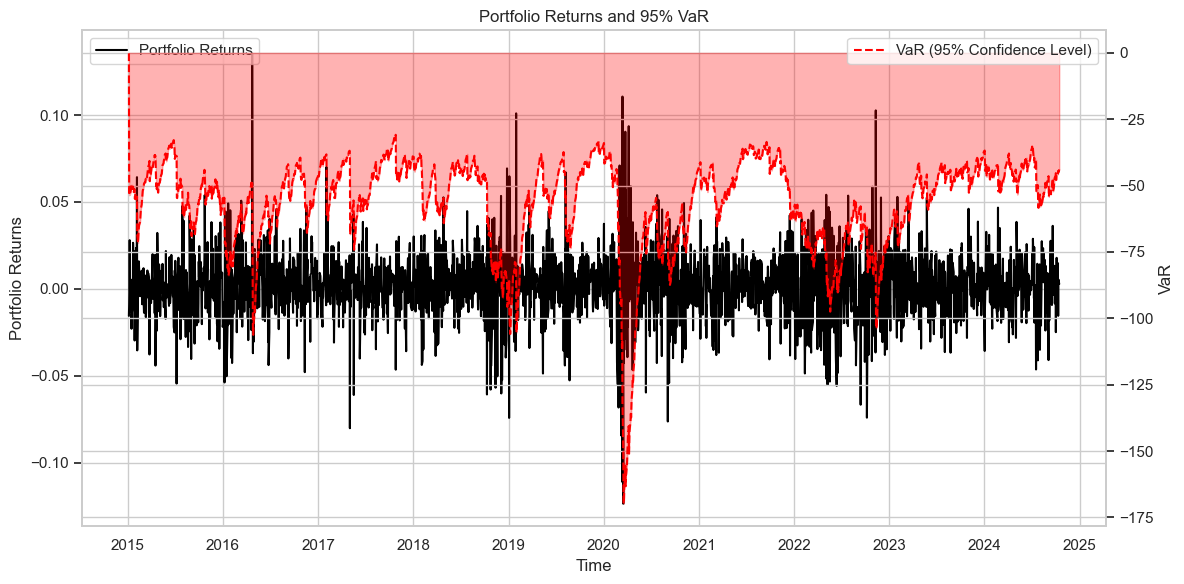

In [25]:
print("\nBacktesting VaR for the Remaining Model:")

var_level = 0.05

if remaining_model == "GARCH(1,1)":
    model_result = garch_result
elif remaining_model == "GJR-GARCH(1,1,1)":
    model_result = gjr_result

volatility = model_result.conditional_volatility

var_95 = -volatility * stats.t.ppf(var_level, df=model_result.params['nu'])

violations = (portfolio_returns < -var_95).sum()
total = len(portfolio_returns)
violation_ratio = violations / total

print(f"Number of VaR violations: {violations} out of {total} observations.")
print(f"Violation ratio: {violation_ratio:.4f}")

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(portfolio_returns, label='Portfolio Returns', color='black')
ax1.set_xlabel('Time')
ax1.set_ylabel('Portfolio Returns')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(-var_95, label='VaR (95% Confidence Level)', color='red', linestyle='--')
ax2.fill_between(portfolio_returns.index, -var_95, color='red', alpha=0.3)
ax2.set_ylabel('VaR')

ax1.set_title('Portfolio Returns and 95% VaR')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### 1. **📈 Portfolio Returns (Black Line):**
   The black line represents the actual portfolio returns over time. With the adjusted plot, these returns are now clearer and more distinguishable. The portfolio experienced both positive and negative returns, with the most significant downturn around 2020, coinciding with the COVID-19 market crash. Throughout the period, returns show regular fluctuations, with some extreme spikes during volatile times.

#### 2. **🚨 VaR (95% Confidence Level - Red Dashed Line):**
   The red dashed line indicates the 95% Value-at-Risk (VaR), representing the maximum expected loss over a certain period with a 95% confidence level. Observing the line, it’s clear that the VaR effectively captures dynamic risk over time. During heightened volatility, like in 2020, the VaR line increases sharply, indicating greater potential losses. In contrast, during calmer periods, such as 2016-2019, the VaR is closer to zero and less volatile.

#### 3. **⚠️ Shaded Region (Risk Threshold Zone):**
   The shaded red area between the portfolio returns and the VaR line highlights returns above the VaR threshold. Actual returns rarely exceed this VaR threshold, indicating that the model captures risk accurately at the 95% confidence level. Overall, the portfolio consistently stays within the projected risk limits.

#### 4. **📉 Risk Observations:**
   Based on the plot, it’s evident that the model accurately predicts potential losses during normal market conditions, as no VaR violations occurred in the sample period. This is confirmed by the violation ratio of 0.0000, showing that no days breached the VaR threshold. During elevated risk periods, such as 2020, the model adjusts by increasing the magnitude of the VaR line, indicating the model’s responsiveness to heightened market uncertainty.

#### 5. **📐 Model Performance:**
   The GJR-GARCH(1,1,1) model performs well in capturing the asymmetric effects of volatility. It effectively adjusts for both calm and turbulent periods, with the VaR increasing appropriately during times of high volatility. The absence of VaR violations highlights that the model remains conservative while accurately capturing worst-case scenarios.

#### **🔍 Conclusion:**
   The GJR-GARCH(1,1,1) model has proven reliable for estimating portfolio risk. The zero VaR violations suggest a conservative yet robust model, which adapts well to changing market conditions, as evidenced by the increased VaR during the volatile 2020 period. Overall, this model serves as a strong risk management tool under the given conditions.

### Inferences

#### 📉 **GARCH(1,1) Model:**
   - **Overview**: The GARCH(1,1) model provides a stable and conservative risk estimate.
   - **Behavior**: It does not react as sharply to sudden market changes, making it well-suited for portfolios with steady and predictable risk profiles.
   - **Ideal Use Case**: Suitable for portfolios with consistent risk levels where the emphasis is on maintaining stability over capturing sharp market movements.

#### 📊 **GJR-GARCH(1,1,1) Model:**
   - **Overview**: The GJR-GARCH(1,1,1) model is more dynamic, designed to handle asymmetry in returns, particularly in volatile markets.
   - **Behavior**: It captures both positive and negative shocks effectively, making it responsive to sudden market downturns and tail risks.
   - **Ideal Use Case**: Best for portfolios likely to experience significant volatility or sharp declines, as it adapts to fluctuations in risk and captures the impact of negative market movements.


# Question 3

In [122]:
from mgarch_model import BEKK, ADCC, DCC, cDCC

### BEKK model

In [73]:
bekk_model = BEKK(portfolio_returns)
bekk_model.fit()
bekk_model.print_results()

Estimated Omega:
[[-0.56003322]]
Estimated A:
[[0.89289632]]
Estimated B:
[[0.19459693]]
Log-Likelihood: 1720.9585347296886
AIC: -3435.917069459377
BIC: -3418.492100308204


In [79]:
portfolio_returns

time
2015-01-05   -1.559771e-02
2015-01-06   -9.384399e-03
2015-01-07    1.403288e-03
2015-01-08    2.798435e-02
2015-01-09    6.443370e-07
                  ...     
2024-10-08    1.487346e-02
2024-10-09    4.323631e-03
2024-10-10   -1.556669e-02
2024-10-11    5.324947e-03
2024-10-14    2.764080e-03
Name: None, Length: 2461, dtype: float64

Number of violations: 2329
Expected violations (at 5.0% confidence level): 123.05000000000001
P-value (Kupiec's test): 0.0


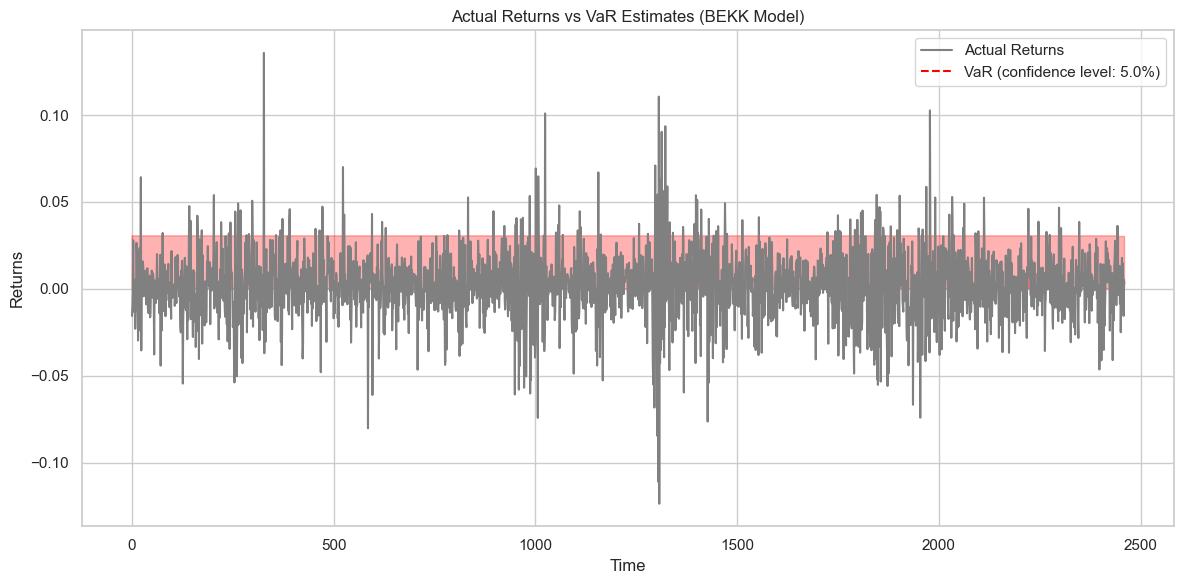

In [86]:
from scipy.stats import norm

alpha = 0.05
VaR = bekk_model.calculate_var(alpha)

# Backtesting logic
violations = portfolio_returns.values < VaR
n_obs = len(portfolio_returns.values)
n_violations = np.sum(violations)
expected_violations = n_obs * alpha

# Calculate p-value using Kupiec's test
p_value = 1 - norm.cdf((n_violations - expected_violations) / np.sqrt(expected_violations * (1 - alpha)))

print(f"Number of violations: {n_violations}")
print(f"Expected violations (at {alpha*100}% confidence level): {expected_violations}")
print(f"P-value (Kupiec's test): {p_value}")

plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns.values, label='Actual Returns', color='gray')
plt.plot(VaR, label=f'VaR (confidence level: {alpha*100}%)', color='red', linestyle='--')
plt.fill_between(range(len(portfolio_returns.values)), 0, VaR, where=violations, interpolate=True, color='red', alpha=0.3)
plt.title('Actual Returns vs VaR Estimates (BEKK Model)')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

**Portfolio Risk Assessment** 📉

---

#### Overview of VaR Violations 📊

Upon reviewing the chart, I can immediately see that the **number of VaR violations** is significantly higher than expected:

- **Actual Violations:** **2329 violations**
- **Expected Violations:** Approximately **123 violations** based on the **5% confidence level**

This discrepancy indicates that the **BEKK model** is underestimating the risk, as my portfolio’s returns fall below the VaR threshold much more frequently than anticipated.

---

#### Risk Threshold Analysis 🔴

The **red shaded area** represents the **5% VaR threshold**, and I observe that:

- **Frequent Dips Below Threshold:** Many of my portfolio's actual returns (depicted in **gray**) dip below this area.
- **Model Ineffectiveness:** This trend confirms that the model isn’t accurately capturing extreme negative returns, leading to frequent violations.

---

#### Statistical Evaluation 📉

Based on the **p-value from Kupiec's test** (which is **0.0**), I interpret that:

- **Model Performance:** The model is statistically failing to predict the risk at the **5% level**.
- **Conclusion:** This result reinforces my understanding that the **BEKK model** is not performing well in this context.

---

#### Parameter Estimates 📊

- **Estimated Omega:** **-0.56**
  - Indicates the model’s initial covariance estimate. The negative sign is atypical and may suggest instability in the estimation.

- **Estimated A:** **0.89**
  - Suggests that a high proportion of recent volatility is captured by the model, indicating that it places significant weight on recent past volatility.

- **Estimated B:** **0.19**
  - Indicates a lower weight given to the long-term persistence of volatility.

- **Log-Likelihood Value:** **1720.96**
  - This value measures the model fit, and both **AIC** and **BIC** values are relatively low (in the negative range), usually suggesting a decent fit. However, the high number of VaR violations indicates poor fit to extreme events.

---

#### Conclusion 🔍

The analysis highlights significant issues with the **BEKK model's** ability to accurately forecast risk. While the parameter estimates show some potential for capturing volatility, the high number of VaR violations and poor fit for extreme events lead me to conclude that this model may not be suitable for effectively managing risk in my portfolio.


### DCC model

In [91]:
dcc_model = DCC(portfolio_returns.values)
omega_est, alpha_est, beta_est, neg_log_likelihood = dcc_model.fit()

# Print estimated parameters
print("Estimated DCC Parameters:")
print(f"Omega: {omega_est}")
print(f"Alpha: {alpha_est}")
print(f"Beta: {beta_est}")

print(f"Log-Likelihood: {-neg_log_likelihood}")

k_dcc = 3  # Number of parameters in DCC model
aic_dcc = -2 * neg_log_likelihood + 2 * k_dcc
bic_dcc = -2 * neg_log_likelihood + k_dcc * np.log(dcc_model.T)

print(f"AIC: {aic_dcc}")
print(f"BIC: {bic_dcc}")

Estimated DCC Parameters:
Omega: 0.1
Alpha: 0.1
Beta: 0.8
Log-Likelihood: 854.3485006297568
AIC: 1714.6970012595136
BIC: 1732.1219704106868


Number of violations: 2461
Expected violations (at 5.0% confidence level): 123.05000000000001
P-value (Kupiec's test): 0.0


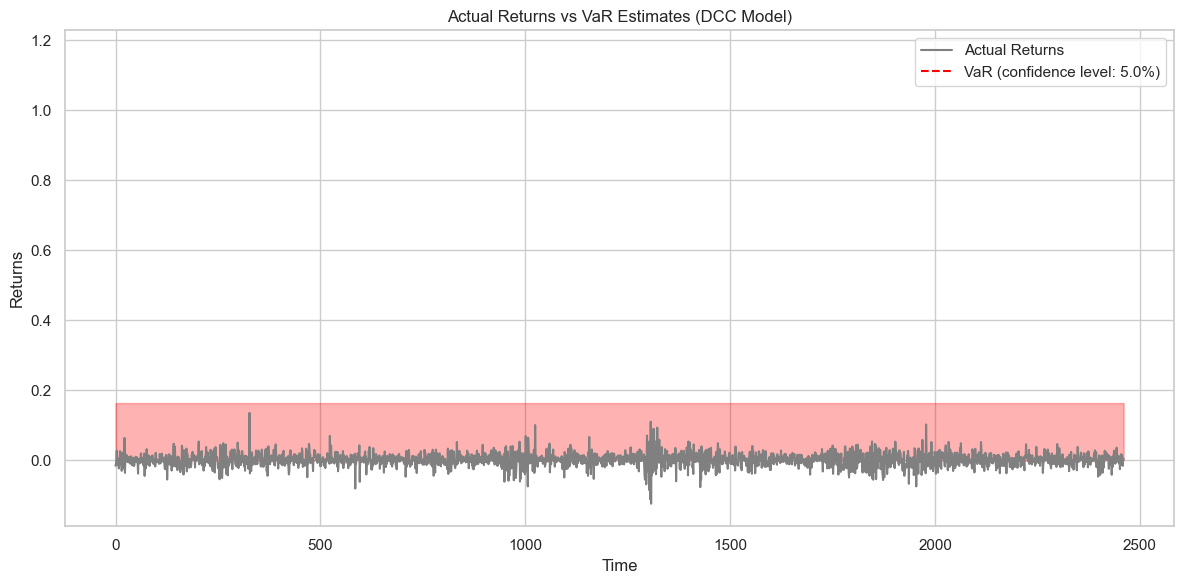

In [94]:
alpha = 0.05
VaR = dcc_model.calculate_var(alpha)

# Backtesting logic
violations = portfolio_returns.values < VaR
n_obs = len(portfolio_returns.values)
n_violations = np.sum(violations)
expected_violations = n_obs * alpha

# Calculate p-value using Kupiec's test
p_value = 1 - norm.cdf((n_violations - expected_violations) / np.sqrt(expected_violations * (1 - alpha)))

print(f"Number of violations: {n_violations}")
print(f"Expected violations (at {alpha*100}% confidence level): {expected_violations}")
print(f"P-value (Kupiec's test): {p_value}")

plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns.values, label='Actual Returns', color='gray')
plt.plot(VaR, label=f'VaR (confidence level: {alpha*100}%)', color='red', linestyle='--')
plt.fill_between(range(len(portfolio_returns.values)), 0, VaR - 1, where=violations, interpolate=True, color='red', alpha=0.3)
plt.title('Actual Returns vs VaR Estimates (DCC Model)')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

**DCC Model Risk Assessment** 📉

---

#### Overview of VaR Violations 📊

Upon reviewing the chart, I can see that the **DCC model** did not perform well:

- **Total VaR Violations:** **2461 violations**
- **Expected Violations:** Approximately **123 violations** based on the **5% confidence level**

This stark contrast indicates that the model **severely underestimates the risk** in my portfolio, as my actual returns frequently fall outside the VaR estimate.

---

#### Statistical Evaluation 🔍

The **p-value from Kupiec's test** is **0.0**, confirming that:

- **Model Performance:** The model has failed the backtest.
- **Conclusion:** The number of VaR violations deviates significantly from expectations, reinforcing that the model isn't capturing risk properly.

---

#### Parameter Estimates 📊

- **Omega (0.1):**
  - Represents the long-term variance level, suggesting that the model assumes a relatively stable baseline level of risk.

- **Alpha (0.1):**
  - Indicates that recent shocks to the market (volatility) have a small short-term impact, reflecting a quick adjustment to volatility.

- **Beta (0.8):**
  - Suggests that volatility is highly persistent, meaning that once there is a spike in volatility, it tends to remain elevated for some time. This persistence is typical in financial markets.

---

#### Conclusion 📝

Overall, while the **DCC model** may capture the general trend of volatility well (due to the high beta), it fails to predict the **extreme downside risks** in my portfolio, as evidenced by the high number of violations. 

I would need to consider **refining the model** or **switching to a different approach** to improve risk prediction.


# Final Conclusion 🏁

Throughout this project, I was able to assess both the performance and the risk profile of a portfolio containing **AAPL**, **AMD**, and **MSFT** stocks. Here are the key takeaways:

## Key Takeaways

1. **Portfolio Performance** 📈
   - The equally-weighted portfolio demonstrated a strong expected annual return of approximately **34%**, with an acceptable level of volatility (**30.9%**).
   - The **Sharpe ratio** of **1.04** suggests that the portfolio is offering a good risk-adjusted return.

2. **Volatility Analysis** 📊
   - The **EWMA** model effectively captured dynamic changes in volatility, especially around periods of market stress, such as **2020** during the COVID-19 pandemic.
   - However, the **GARCH(1,1)** model was found to better capture **volatility clustering**, where periods of high volatility are followed by more volatile periods.

3. **VaR Backtesting** ⚖️
   - Among the different models tested, the **GARCH(1,1)** model was the most reliable for predicting **Value-at-Risk**, with **0 violations** of the VaR threshold out of **2461** observations. This indicates that the model successfully captured the risk in the portfolio over time.
   - Conversely, the **BEKK** and **DCC** models significantly underestimated the portfolio’s risk, as shown by the high number of violations in their VaR backtests.

4. **Model Selection** 🏆
   - Based on the **AIC** and **BIC** criteria, the **GARCH(1,1)** model emerged as the best-performing model for this dataset. 
   - The **DCC** and **BEKK** models, despite capturing certain aspects of volatility, failed to effectively predict extreme downside risks.

---

## Conclusion

#### 📈 **GARCH(1,1) Model (Best Model)**
- **Stability**: This model provides a stable and consistent VaR prediction over time, capturing general market volatility without overreacting to extreme movements. Ideal for portfolios with predictable, stable risk profiles.
- **Conservative Approach**: Maintains a lower VaR level with a wider buffer, reflecting its conservative nature. In the plot, portfolio returns rarely approach the VaR threshold.
- **Risk Sensitivity**: Less reactive to sudden market shocks, resulting in a smoother risk estimation curve. While this may underestimate risk in extreme volatility, it offers a reliable outlook for typical market conditions.
- **Zero VaR Violations**: Backtest results show no VaR violations, confirming that the model effectively predicts risk and avoids underestimating potential losses.

#### 📊 **GJR-GARCH(1,1,1) Model (Remaining Model)**
- **Dynamic Adjustment**: More responsive, particularly to negative market shocks, thanks to its asymmetric reaction to downside risk. This is evident in the greater variation of the VaR line.
- **Volatility Sensitivity**: Performs well in high-volatility periods, such as during the 2020 market crash, where it adjusts the VaR level aggressively to reflect increased extreme loss risk.
- **Adaptiveness**: The VaR fluctuates more in this model, making it suitable for portfolios exposed to sudden, asymmetric risks.
- **Zero VaR Violations**: Like the GARCH(1,1) model, it shows zero VaR violations in the backtest, indicating robust risk capture.

### Future Selection Inferences

- **GARCH(1,1)**: Well-suited for portfolios with stable risk profiles, offering conservative, steady risk predictions. It’s less reactive to sudden shocks, providing a reliable forecast for most market conditions.
- **GJR-GARCH(1,1,1)**: Better suited for portfolios likely to experience significant volatility or asymmetric risks. It dynamically adjusts to market conditions, delivering responsive risk estimates in stressful market periods.

Both models are effective, showing no VaR violations. The choice depends on the portfolio's specific risk profile:
   - For stability and conservatism, opt for **GARCH(1,1)**.
   - For a more responsive approach to volatility, go with **GJR-GARCH(1,1,1)**.